In [1]:


import matplotlib.pyplot as plt

import numpy as np
import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es
import keras
import pandas as pd
from keras.layers import  Conv3D, Flatten, Dense, Reshape,MaxPool3D
from keras.layers import Dropout, Input, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

import plotly.graph_objects as go
import plotly.express as px

from plotly.offline import init_notebook_mode
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral
from time import time
init_notebook_mode(connected=True)
%matplotlib inline


In [2]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.6
windowSize = 25

In [3]:
def loadData(name):
    if name=='IP':
        data = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
        labels = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']
    
    return data,labels
data,labels=loadData(dataset)

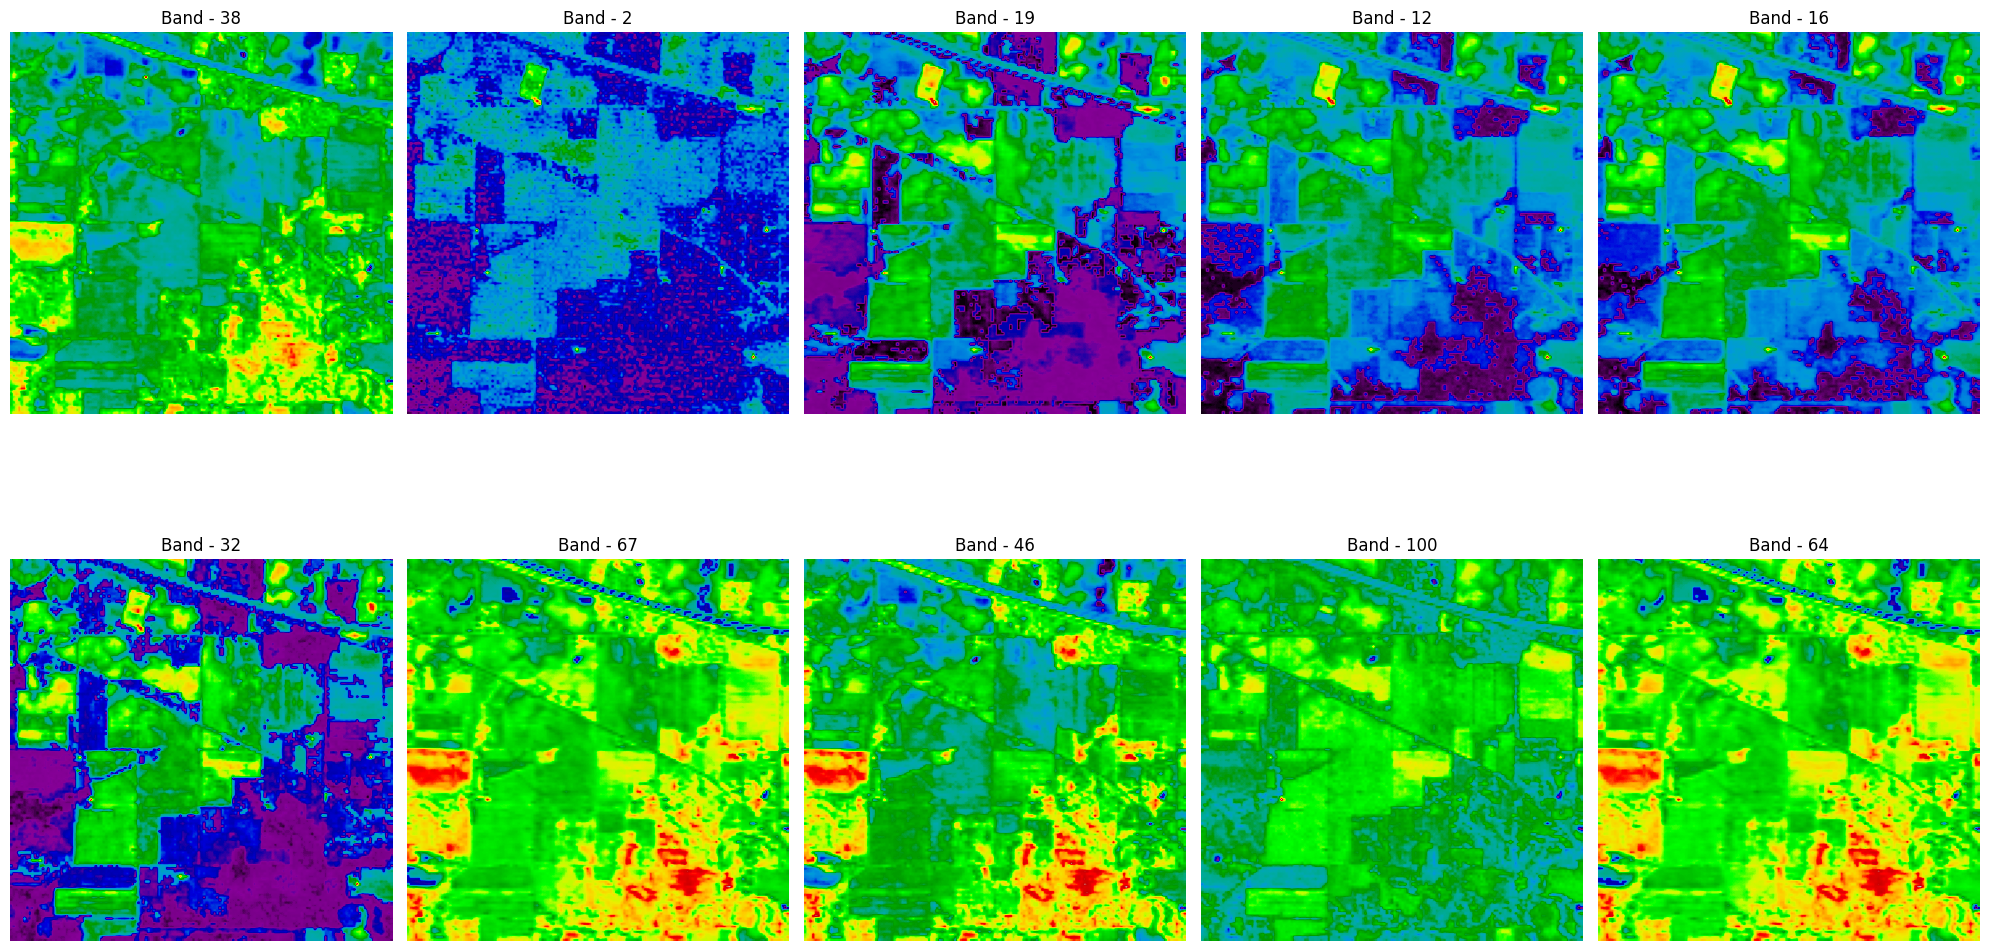

In [4]:
fig = plt.figure(figsize = (20, 12))

ax = fig.subplots(2, 5)

for i in range(2):
  for j in range(5):
    c = np.random.randint(103)
    ax[i][j].imshow(data[:, :, c], cmap='nipy_spectral')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Band - {c}")
    c+=1

plt.tight_layout()
plt.show()

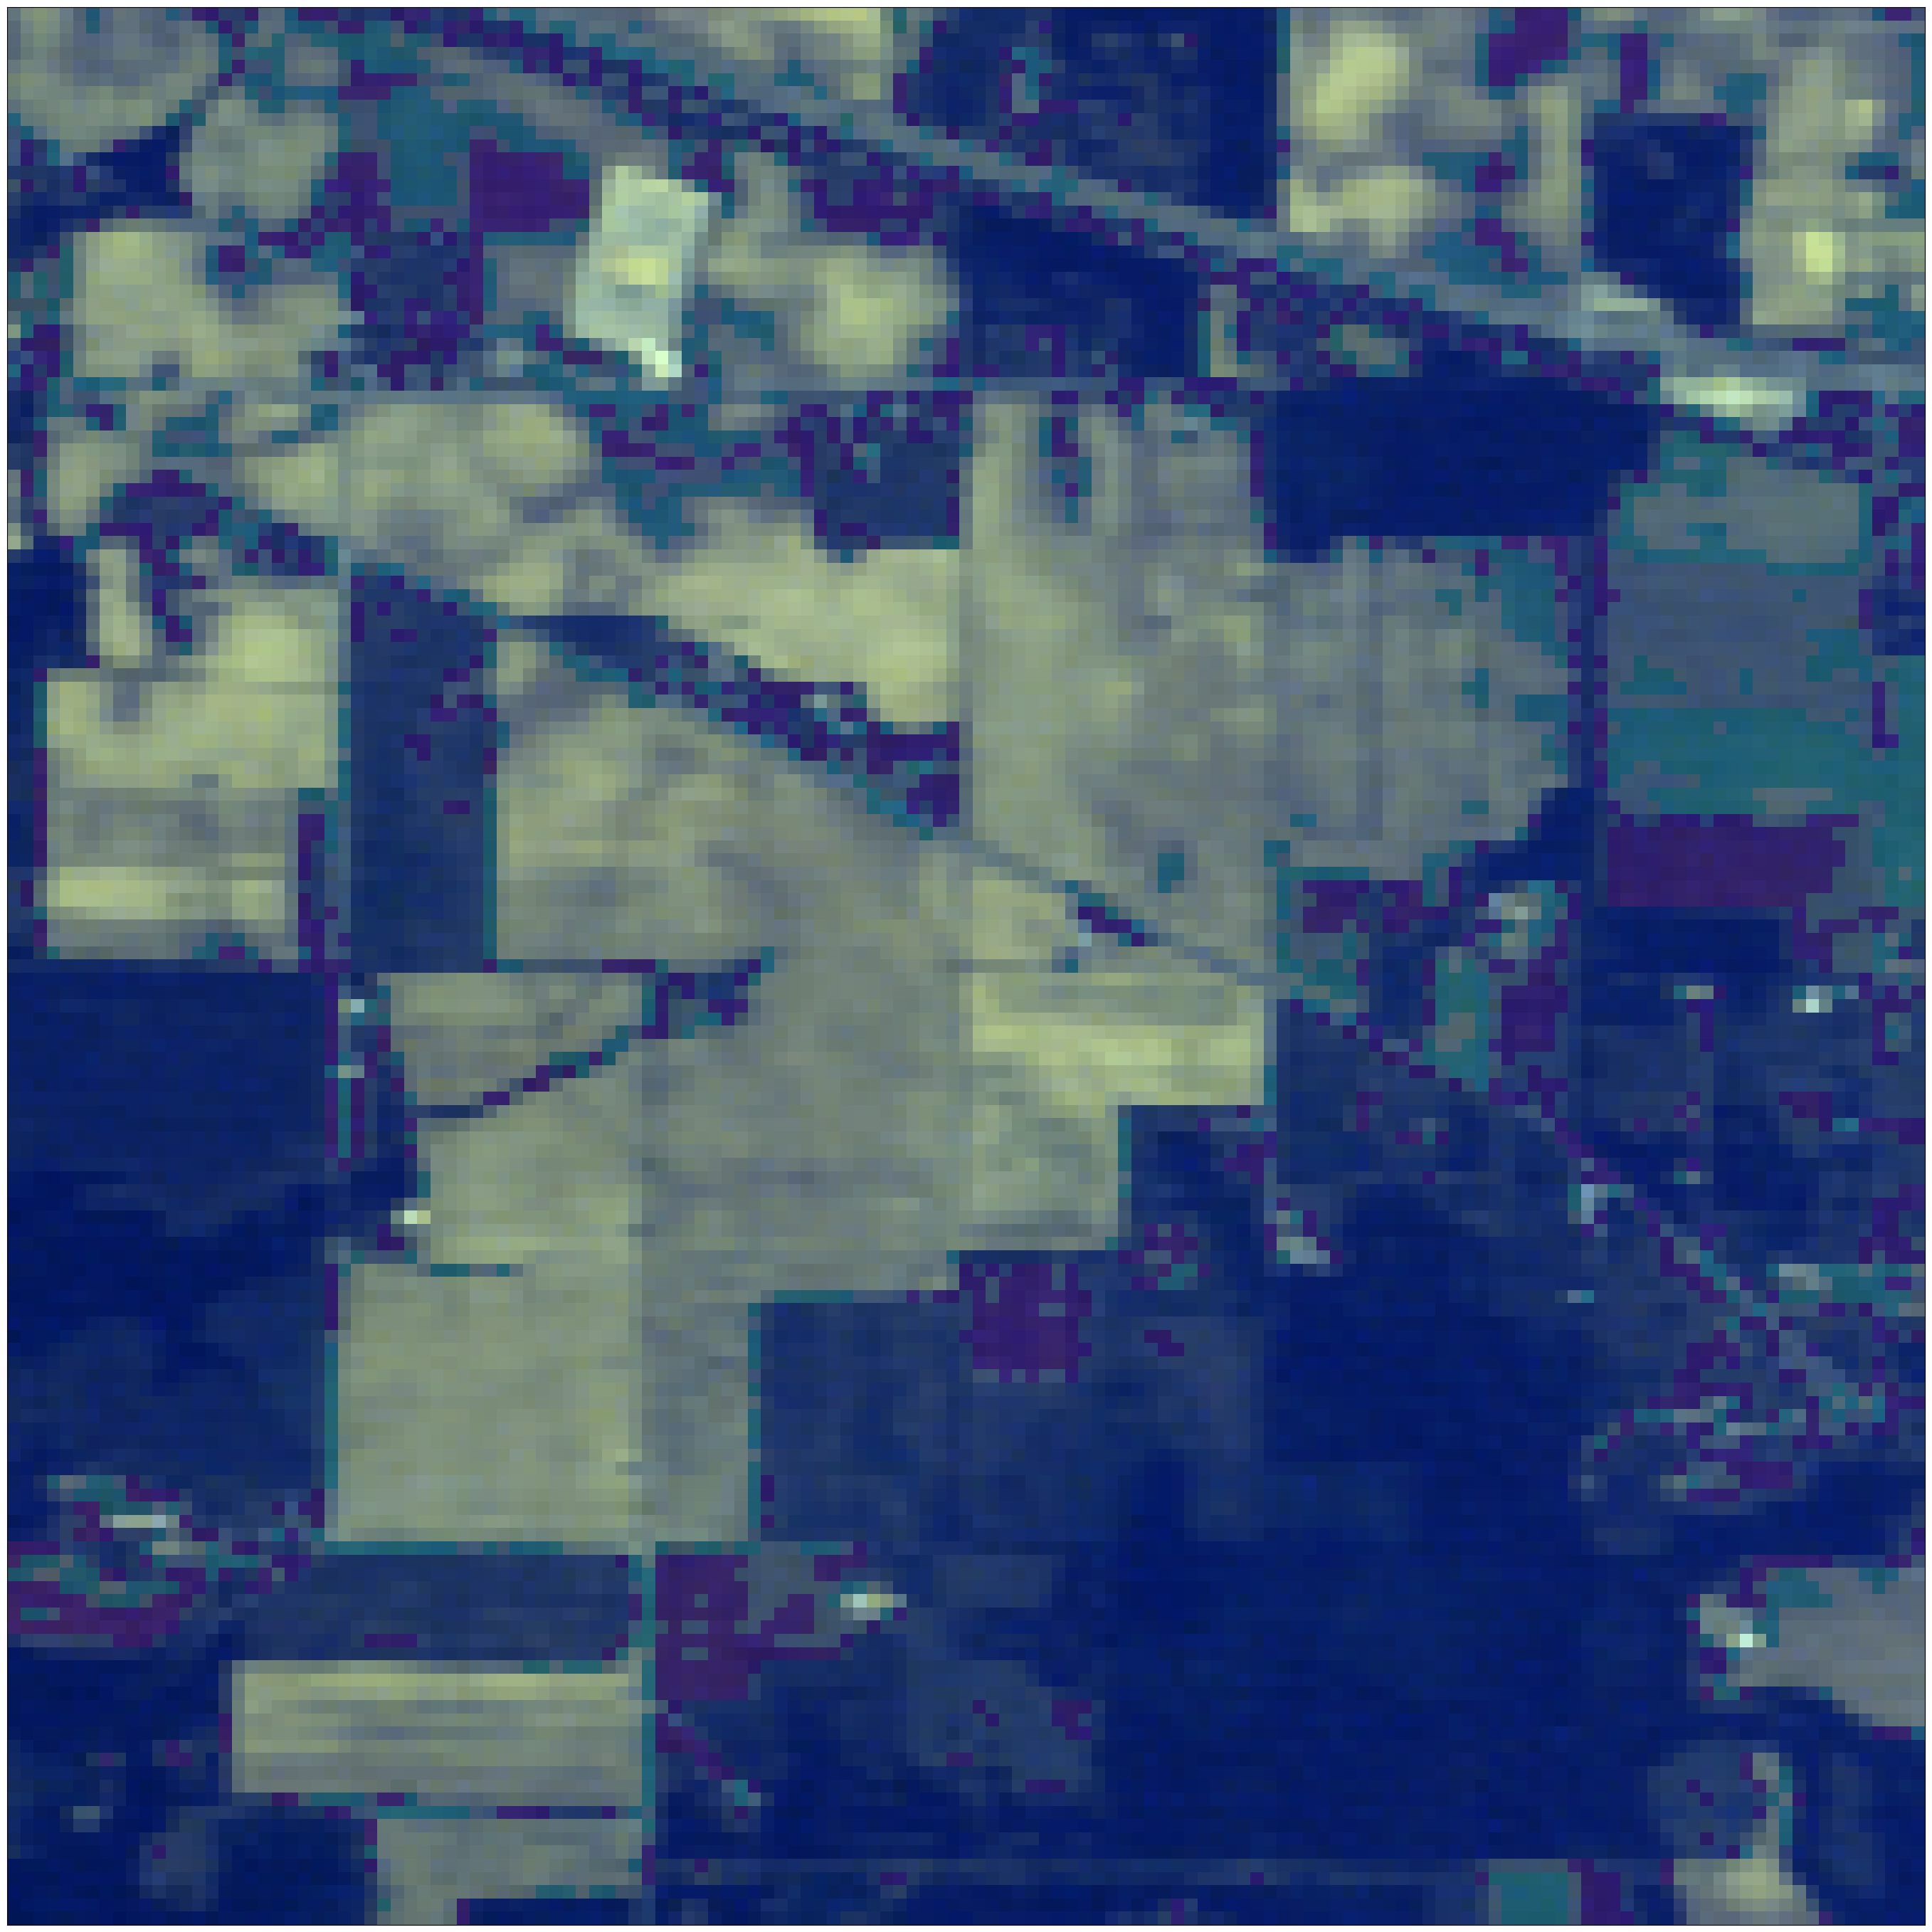

In [5]:
mdata = np.moveaxis(data, -1, 0)

ep.plot_rgb(mdata, (29, 23, 2), figsize=(35, 35)) 

plt.show()

In [6]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [7]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca


In [8]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [9]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX =padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [10]:
X,y = loadData(dataset)
X.shape, y.shape



((145, 145, 200), (145, 145))

In [11]:
K = X.shape[2]



In [12]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

In [13]:
X.shape

X, y = createImageCubes(X, y, windowSize=windowSize)


In [14]:
X.shape, y.shape, np.min(y),np.max(y)

((10249, 25, 25, 30), (10249,), 0.0, 15.0)

In [15]:
X_train, X_test, y_train, y_test = splitTrainTestSet(X, y, test_ratio)
X_train, X_val, y_train, y_val = splitTrainTestSet(X_train, y_train, test_ratio)

In [16]:
X_train = X_train.reshape(-1, windowSize, windowSize, K, 1)
y_train.shape


(1639,)

In [17]:
y_train = to_categorical(y_train)
y_train.shape


(1639, 16)

In [18]:
y_val=to_categorical(y_val)
y_val.shape

(2460, 16)

In [19]:
y_test=to_categorical(y_test)
y_test.shape

(6150, 16)

In [20]:
y_train.shape, y_val.shape, y_test.shape

((1639, 16), (2460, 16), (6150, 16))

In [21]:
X_train.shape, X_val.shape, X_test.shape

((1639, 25, 25, 30, 1), (2460, 25, 25, 30), (6150, 25, 25, 30))

In [22]:
S = windowSize
L = K
output_units =  9 if(dataset== 'PU' or dataset=='PC') else 16


In [23]:
input_layer = Input((S, S, L, 1))

In [24]:
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
pooling_layer1 = MaxPool3D(pool_size=(2,2,2))(conv_layer2)


conv_layer3 = Conv3D(filters=32, kernel_size=(3,3,3), activation='relu')(conv_layer2)
pooling_layer2=MaxPool3D(pool_size=(2,2,2))(conv_layer3)
                     
pooling_layer2=BatchNormalization()(pooling_layer2)
                     

flatten_layer = Flatten()(pooling_layer2)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

model = Model(inputs=input_layer, outputs=output_layer)

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 25, 30, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 23, 23, 24, 8)     512       
                                                                 
 conv3d_1 (Conv3D)           (None, 21, 21, 20, 16)    5776      
                                                                 
 conv3d_2 (Conv3D)           (None, 19, 19, 18, 32)    13856     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 9, 9, 9, 32)       0         
 g3D)                                                            
                                                                 
 batch_normalization (Batch  (None, 9, 9, 9, 32)       128       
 Normalization)                                              

In [26]:
adam = Adam(learning_rate=0.001, weight_decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [27]:
early_stop = EarlyStopping(monitor = 'val_loss',
                            mode = 'min',
                            min_delta = 0,
                            patience = 10,
                            restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'best-model.keras', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True)

tensorboard = TensorBoard(log_dir='SA_logs/{}'.format(time()))

In [28]:
filepath = "best-model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,early_stop,checkpoint,tensorboard]
validation_data=(X_val,y_val)

In [29]:
history = model.fit(x=X_train,y= y_train,epochs=120, batch_size=256,validation_data=(X_val,y_val), callbacks=callbacks_list)


Epoch 1/120
7/7 [==============================] - 89s 13s/step - loss: 3.2457 - accuracy: 0.3667 - val_loss: 2.5487 - val_accuracy: 0.3793
Epoch 2/120
7/7 [==============================] - 87s 13s/step - loss: 0.9225 - accuracy: 0.7132 - val_loss: 2.4731 - val_accuracy: 0.6415
Epoch 3/120
7/7 [==============================] - 88s 13s/step - loss: 0.3786 - accuracy: 0.8890 - val_loss: 2.2876 - val_accuracy: 0.5293
Epoch 4/120
7/7 [==============================] - 86s 12s/step - loss: 0.1989 - accuracy: 0.9402 - val_loss: 2.2023 - val_accuracy: 0.5557
Epoch 5/120
7/7 [==============================] - 86s 13s/step - loss: 0.1260 - accuracy: 0.9646 - val_loss: 2.1640 - val_accuracy: 0.6183
Epoch 6/120
7/7 [==============================] - 86s 12s/step - loss: 0.0847 - accuracy: 0.9750 - val_loss: 2.1056 - val_accuracy: 0.5854
Epoch 7/120
7/7 [==============================] - 86s 12s/step - loss: 0.0529 - accuracy: 0.9847 - val_loss: 1.9876 - val_accuracy: 0.6195
Epoch 8/120
7/7 [===

In [32]:
model.save("best-model.keras")

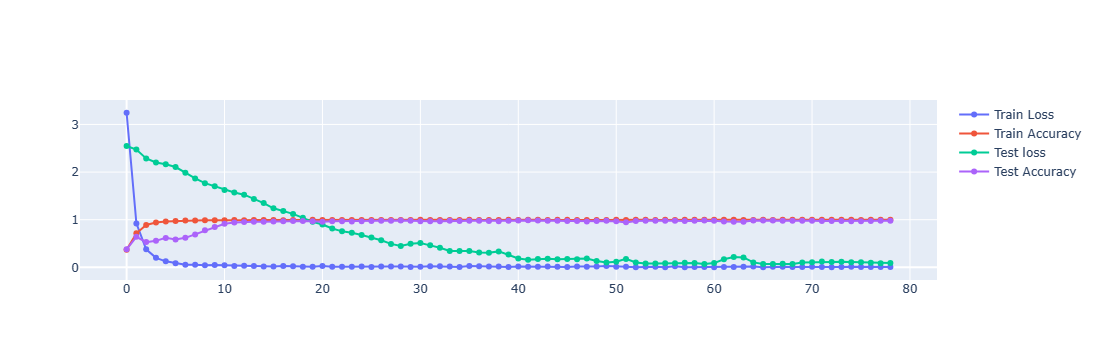

In [33]:
hist = pd.DataFrame(data= history.history)

fig = go.Figure()

fig.add_trace(go.Scatter(x = hist.index, y = hist.loss.values,
                    mode='lines+markers',
                    name='Train Loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.accuracy.values,
                    mode='lines+markers',
                    name='Train Accuracy'))


fig.add_trace(go.Scatter(x = hist.index, y = hist.val_loss.values,
                    mode='lines+markers', name='Test loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_accuracy.values,
                    mode='lines+markers', name='Test Accuracy'))

fig.show()

In [39]:
X_test = X_test.reshape(-1, windowSize, windowSize, K, 1)
X_test.shape


(6150, 25, 25, 30, 1)

In [40]:
#y_test = to_categorical(y_test)
y_test.shape

(6150, 16)

In [41]:
Y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(Y_pred_test, axis=1)

193/193 [==============================] - 72s 369ms/step


In [42]:
classification = classification_report(np.argmax(y_test, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        27
           1       0.99      0.96      0.98       857
           2       0.93      1.00      0.96       498
           3       0.99      0.94      0.96       142
           4       0.96      0.96      0.96       290
           5       0.99      0.98      0.98       438
           6       1.00      0.76      0.87        17
           7       1.00      1.00      1.00       287
           8       1.00      0.75      0.86        12
           9       0.97      0.99      0.98       583
          10       0.99      0.99      0.99      1473
          11       0.99      0.95      0.97       356
          12       0.98      1.00      0.99       123
          13       1.00      1.00      1.00       759
          14       0.95      0.99      0.97       232
          15       0.96      0.91      0.94        56

    accuracy                           0.98      6150
   macro avg       0.98   

In [43]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [44]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
  
   
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [45]:
def reportsn(X_test,y_test):
    
    
    Y_pred=model.predict(X_test)
    y_pred = np.argmax (Y_pred, axis=1)
    target_names =['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Background']

    classification1 = classification_report(np.argmax (y_test, axis=1), y_pred, target_names=target_names) 
    confusion1=confusion_matrix (np.argmax (y_test, axis=1), y_pred)
    score1 = model.evaluate (X_test, y_test, batch_size=32)
    Test_Loss1 =score1[0]*100
    Test_accuracy1 = score1[1]*100
    return classification1, confusion1, Test_Loss1, Test_accuracy1, score1

In [46]:
classifcation1,confusion1, Test_Loss1, Test_accuracy1, score1=reportsn(X_test,y_test)

print(classification,confusion1, Test_Loss1, Test_accuracy1, score1)


193/193 [==============================] - 73s 377ms/step - loss: 0.0616 - accuracy: 0.9798
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        27
           1       0.99      0.96      0.98       857
           2       0.93      1.00      0.96       498
           3       0.99      0.94      0.96       142
           4       0.96      0.96      0.96       290
           5       0.99      0.98      0.98       438
           6       1.00      0.76      0.87        17
           7       1.00      1.00      1.00       287
           8       1.00      0.75      0.86        12
           9       0.97      0.99      0.98       583
          10       0.99      0.99      0.99      1473
          11       0.99      0.95      0.97       356
          12       0.98      1.00      0.99       123
          13       1.00      1.00      1.00       759
          14       0.95      0.99      0.97       232
          15       0.96      0.91      0.94

In [47]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(X_test,y_test,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report1.txt"


193/193 [==============================] - 68s 354ms/step - loss: 0.0616 - accuracy: 0.9798


In [48]:
with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))


In [49]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [50]:
X, y = loadData(dataset)

In [51]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [52]:
X,pca = applyPCA(X, numComponents=numComponents)

In [53]:
X = padWithZeros(X, PATCH_SIZE//2)

In [54]:
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

1/1 [==============================] - 0s 71ms/step


C:\Users\sachi\AppData\Local\Programs\Python\Python311\Lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.



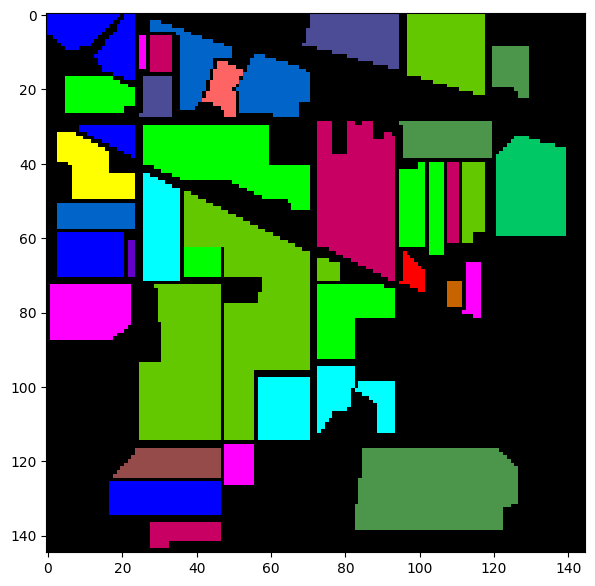

In [55]:

ground_truth = spectral.imshow(classes = y,figsize =(7,7))

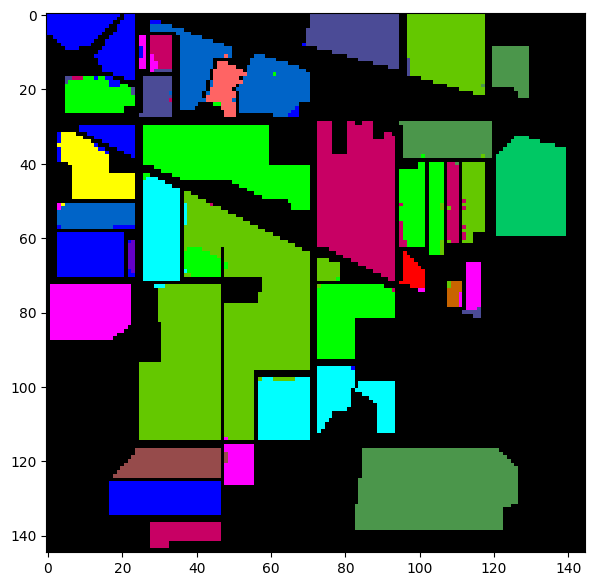

In [56]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [57]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

In [58]:
def Estimate_Area(spatial_resolution, label, n_class, class_to_crop_name_mapping):
  Count = [0]* n_class
  Count = np.array(Count)
  for i in range(label.shape[0]):
    for j in range(label.shape[1]):
      idx = int(label[i][j])
      Count[idx] +=1

  area_of_one_pixel = float(spatial_resolution * spatial_resolution)
  for i in range(n_class):
    print("Area of "+class_to_crop_name_mapping[i]+" == ","{0:.2f}".format((Count[i]*area_of_one_pixel)), "square metre")



In [59]:

class_to_crop_name_mapping = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Background']

spatial_resolution_of_IP_dataset = 3.7
outputs = outputs -1


In [60]:
Estimate_Area(spatial_resolution_of_IP_dataset, outputs, 16, class_to_crop_name_mapping)


              

Area of Alfalfa ==  602.36 square metre
Area of Corn-notill ==  19029.10 square metre
Area of Corn-mintill ==  11978.75 square metre
Area of Corn ==  3107.63 square metre
Area of Grass-pasture ==  6639.65 square metre
Area of Grass-trees ==  9980.01 square metre
Area of Grass-pasture-mowed ==  301.18 square metre
Area of Hay-windrowed ==  6543.82 square metre
Area of Oats ==  219.04 square metre
Area of Soybean-notill ==  13388.82 square metre
Area of Soybean-mintill ==  33691.09 square metre
Area of Soybean-clean ==  7885.44 square metre
Area of Wheat ==  2847.52 square metre
Area of Woods ==  17317.85 square metre
Area of Buildings-Grass-Trees-Drives ==  5558.14 square metre
Area of Stone-Steel-Towers ==  148741.85 square metre
